# Experimento 0.1 : Primera crítica del artículo "A Preliminary Study on Deep Transfer Learning Applied to Image Classification for Small Datasets" análisis de hiper-parámetros.

En este experimento comprobaremos como afecta el tamaño de lotes a la red propuesta en "A Preliminary Study on Deep Transfer Learning Applied to Image Classification for Small Datasets".

## Librerías usadas.

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import math 
from glob import glob
from matplotlib import pyplot as plt
import os
import tensorflow as tf
from tqdm import tqdm
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils import resample

## Parámetros globales

In [11]:
#Rutas de los datos.
 
data_dir = os.path.dirname(os.path.realpath("../TFG/Datos/HAM10000_metadata.csv"))



csv_path = os.path.realpath(data_dir + "/HAM10000_metadata.csv")

#Variables globales

altura = 50
longitud = 50
clases = 7


print(data_dir)

print(csv_path)



/home/antoniojesus/Escritorio/TFG/Datos
/home/antoniojesus/Escritorio/TFG/Datos/HAM10000_metadata.csv


## Creación del marco de datos.

In [5]:
#Inicializando el dataFrame

dataFrame=pd.read_csv(csv_path)

#Mezclando carpetas.

all_image_path = glob(os.path.join(data_dir, '*', '*'))
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in all_image_path}

# Inicializando diccionario de categorías

lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

#Añadiendo columnas al dataFrame para que sea más legible.

dataFrame['path'] = dataFrame['image_id'].map(imageid_path_dict.get)
dataFrame['cell_type'] = dataFrame['dx'].map(lesion_type_dict.get) 
dataFrame['cell_type_idx'] = pd.Categorical(dataFrame['cell_type']).codes
dataFrame.head()


,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,/home/antoniojesus/Escritorio/TFG/Datos/HAM100...,Benign keratosis,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,/home/antoniojesus/Escritorio/TFG/Datos/HAM100...,Benign keratosis,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,/home/antoniojesus/Escritorio/TFG/Datos/HAM100...,Benign keratosis,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,/home/antoniojesus/Escritorio/TFG/Datos/HAM100...,Benign keratosis,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,/home/antoniojesus/Escritorio/TFG/Datos/HAM100...,Benign keratosis,2


## Select_network

Este método permite seleccionar la parte superior de una red.

In [6]:
def select_network(nn_base_arch):

    if nn_base_arch =='CNN_SOCO':
        nn = cnn_soco()
        
    return nn

## Los métodos que se describen acontinuación permitirán crear diferentes tipos de capas superiores que se usarán en el método select_network. Los métodos son : 

 - cnn_soco = Es una réplica de la red usada en el estudio "A Preliminary Study on Deep Transfer Learning Applied to Image Classification for Small Datasets".


In [7]:
def cnn_soco():
    
    model = tf.keras.Sequential()
    
    model.add(tf.keras.layers.Conv2D(32, (3,3),(1,1), activation='relu',input_shape=(altura,longitud,3)))
    model.add(tf.keras.layers.Conv2D(32, (3,3),(1,1),activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D((2,2)))

 
    model.add(tf.keras.layers.Conv2D(64, (3,3), activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D((2,2)))
    
    return model

Los métodos que se describen a continuación generarán la capa de salida de nuestra red : 
 - build = Réplica de una red del estudio, de cara a entender las modificaciones leer el experimento 0

In [8]:
def build(nn):
    model = tf.keras.Sequential()
    model.add(nn)
    model.add(tf.keras.layers.Flatten())
    
    model.add(tf.keras.layers.Dense(128))
    model.add(tf.keras.layers.Activation('relu'))

    model.add(tf.keras.layers.Dense(clases,activation='softmax'))


    return model

In [20]:
nn = select_network('CNN_SOCO')
model = build(nn)

## Se procede a crear un método que permita balancear la carga de imágenes

In [12]:
def balanced_dataset(df):
    df_balanced = pd.DataFrame()
    #df = pd.DataFrame()
    
    for cat in df['cell_type_idx'].unique():
        temp = resample(df[df['cell_type_idx'] == cat], 
                        replace=True,     # sample with replacement
                        n_samples=2500,   # to match majority class
                        random_state=123) # reproducible results

        # Combine majority class with upsampled minority class
        df_balanced = pd.concat([df_balanced, temp])
 
    df_balanced['cell_type'].value_counts()

    return df_balanced

def load_img_data(size, df, balanced=False):
    """
        ..
        first we should normalize the image from 0-255 to 0-1
    """
    
    img_h, img_w = size, size
    imgs = []
    
    if balanced:
        df = balanced_dataset(df)
    
    image_paths = list(df['path'])

    for i in tqdm(range(len(image_paths))):
        img = cv2.imread(image_paths[i])
        img = cv2.resize(img, (img_h, img_w))
        img = img.astype(np.float32) / 255.
        #img = np.asarray(Image.open(image_paths[i]).resize((size,size)))
        imgs.append(img)

    imgs = np.stack(imgs, axis=0)
    print(imgs.shape)

    #imgs = imgs.astype(np.float32) / 255.
    
    return imgs, df['cell_type_idx'].values

NameError: name 'imgs' is not defined

## Cargamos los datos y generamos información necesaria.

In [14]:
def load_general_data():
    
    imgs, target = load_img_data(altura, dataFrame, balanced=True)
    
    x_train, x_transferLearning, y_train, y_transferLearning = train_test_split(imgs, target, test_size=0.60)
       
    source_data = [ x_transferLearning , y_transferLearning ]
    target_data = [ x_train , y_train ]
    
    x_train,x_test,y_train,y_test = train_test_split(target_data[0], target_data[1], test_size=0.70)
    
    train_data = [x_train,y_train]
    test_data = [x_test,y_test]
    
    return source_data,train_data,test_data


def get_data_for_ex(source_data,train_data,test_data):
    
    x_train = source_data[0]
    y_train = source_data[1]
    
    x_retrain = train_data[0]
    y_retrain = train_data[1]
    
    percent = math.floor(len(test_data[0])/100*30)
       
    x_validation = test_data[0][0:percent]
    y_validation = test_data[1][0:percent]
    
    
    x_test = test_data[0][percent:-1]
    y_test = test_data[1][percent:-1]
    
    return x_train,x_retrain,x_test,x_validation,y_train,y_retrain,y_test,y_validation


###############################################################################################################
# Los primeros 4 métodos son referenetes al tamaño de bach, el exp_5 hace referencia al incremento de EPOCHS  #
###############################################################################################################

def set_hiper_to_exp_1():
    #Hiper-parámetros
    BATCH_SIZE = 128
    EPOCHS = 5
    RMSpropEstudio = tf.keras.optimizers.RMSprop(learning_rate=0.0001)
    
    return BATCH_SIZE,EPOCHS,RMSpropEstudio

def set_hiper_to_exp_2():
    #Hiper-parámetros
    BATCH_SIZE = 64
    EPOCHS = 5
    RMSpropEstudio = tf.keras.optimizers.RMSprop(learning_rate=0.0001)
    
    return BATCH_SIZE,EPOCHS,RMSpropEstudio
    
def set_hiper_to_exp_3():
    #Hiper-parámetros
    BATCH_SIZE = 32
    EPOCHS = 5
    RMSpropEstudio = tf.keras.optimizers.RMSprop(learning_rate=0.0001)
    
    return BATCH_SIZE,EPOCHS,RMSpropEstudio
    
def set_hiper_to_exp_4():
    #Hiper-parámetros
    BATCH_SIZE = 16
    EPOCHS = 5
    RMSpropEstudio = tf.keras.optimizers.RMSprop(learning_rate=0.0001)
    
    return BATCH_SIZE,EPOCHS,RMSpropEstudio

#############################################################################################################

def set_hiper_to_exp_5():
    #Hiper-parámetros
    BATCH_SIZE = 128
    EPOCHS = 30
    RMSpropEstudio = tf.keras.optimizers.RMSprop(learning_rate=0.0001)
    
    return BATCH_SIZE,EPOCHS,RMSpropEstudio


#############################################################################################################

def set_hiper_to_exp_6():
    #Hiper-parámetros
    BATCH_SIZE = 16
    EPOCHS = 25
    RMSpropEstudio = tf.keras.optimizers.RMSprop(learning_rate=0.0001)
    
    return BATCH_SIZE,EPOCHS,RMSpropEstudio






In [15]:
source_data,train_data,test_data = load_general_data()
x_train,x_retrain,x_test,x_validation,y_train,y_retrain,y_test,y_validation = get_data_for_ex(source_data,train_data,test_data)

100%|██████████| 17500/17500 [06:45<00:00, 43.20it/s] 


(17500, 50, 50, 3)


In [ ]:
#Ejecutamos el los experimentos referentes al batch-size(los 4 primeros)

BATCH_SIZE,EPOCHS,RMSpropEstudio = set_hiper_to_exp_1()
res,res1,evaluations,evaluations1 = run_experiment(nn_base_arch,EPOCHS)

BATCH_SIZE,EPOCHS,RMSpropEstudio = set_hiper_to_exp_2()
res,res2,evaluations,evaluations2 = run_experiment(nn_base_arch,EPOCHS)

BATCH_SIZE,EPOCHS,RMSpropEstudio = set_hiper_to_exp_3()
res,res3,evaluations,evaluations3 = run_experiment(nn_base_arch,EPOCHS)

BATCH_SIZE,EPOCHS,RMSpropEstudio = set_hiper_to_exp_4()
res,res4,evaluations,evaluations4 = run_experiment(nn_base_arch,EPOCHS)


In [50]:
#Ejecutamos el experimento referente al tamaños del número de épocas

BATCH_SIZE,EPOCHS,RMSpropEstudio = set_hiper_to_exp_5()
res,res1,evaluations,evaluations1 = run_experiment(nn_base_arch,EPOCHS)

Epoch 1/30
83/83 [==============================] - 25s 306ms/step - loss: 1.8462 - accuracy: 0.2705 - mse: 12.1802 - val_loss: 1.8613 - val_accuracy: 0.2170 - val_mse: 11.8035
Epoch 2/30
83/83 [==============================] - 26s 310ms/step - loss: 1.6664 - accuracy: 0.3691 - mse: 12.1855 - val_loss: 1.9700 - val_accuracy: 0.1837 - val_mse: 11.8219
Epoch 3/30
83/83 [==============================] - 25s 304ms/step - loss: 1.5202 - accuracy: 0.4350 - mse: 12.1919 - val_loss: 1.5869 - val_accuracy: 0.3667 - val_mse: 11.8154
Epoch 4/30
83/83 [==============================] - 26s 310ms/step - loss: 1.4124 - accuracy: 0.4755 - mse: 12.1977 - val_loss: 1.5021 - val_accuracy: 0.4197 - val_mse: 11.8217
Epoch 5/30
83/83 [==============================] - 25s 298ms/step - loss: 1.3382 - accuracy: 0.4984 - mse: 12.2026 - val_loss: 1.4019 - val_accuracy: 0.4497 - val_mse: 11.8206
Epoch 6/30
83/83 [==============================] - 25s 299ms/step - loss: 1.2799 - accuracy: 0.5200 - mse: 12.2062

83/83 - 24s - loss: 0.3946 - accuracy: 0.8651 - mse: 12.2623 - val_loss: 0.6152 - val_accuracy: 0.8007 - val_mse: 11.8749
Epoch 22/30
83/83 - 24s - loss: 0.3826 - accuracy: 0.8741 - mse: 12.2630 - val_loss: 0.7200 - val_accuracy: 0.7224 - val_mse: 11.8787
Epoch 23/30
83/83 - 24s - loss: 0.3707 - accuracy: 0.8788 - mse: 12.2638 - val_loss: 0.8141 - val_accuracy: 0.7116 - val_mse: 11.8767
Epoch 24/30
83/83 - 24s - loss: 0.3645 - accuracy: 0.8810 - mse: 12.2645 - val_loss: 0.8378 - val_accuracy: 0.7320 - val_mse: 11.8800
Epoch 25/30
83/83 - 24s - loss: 0.3479 - accuracy: 0.8851 - mse: 12.2655 - val_loss: 0.6410 - val_accuracy: 0.7653 - val_mse: 11.8740
Epoch 26/30
83/83 - 24s - loss: 0.3428 - accuracy: 0.8874 - mse: 12.2660 - val_loss: 1.5859 - val_accuracy: 0.5762 - val_mse: 11.8830
Epoch 27/30
83/83 - 24s - loss: 0.3420 - accuracy: 0.8890 - mse: 12.2669 - val_loss: 0.5834 - val_accuracy: 0.7918 - val_mse: 11.8792
Epoch 28/30
83/83 - 24s - loss: 0.3251 - accuracy: 0.8955 - mse: 12.2675 -

Epoch 10/30
83/83 - 24s - loss: 0.6059 - accuracy: 0.7886 - mse: 12.2474 - val_loss: 0.8758 - val_accuracy: 0.6612 - val_mse: 11.8604
Epoch 11/30
83/83 - 24s - loss: 0.5882 - accuracy: 0.7993 - mse: 12.2482 - val_loss: 1.0446 - val_accuracy: 0.6000 - val_mse: 11.8586
Epoch 12/30
83/83 - 24s - loss: 0.5845 - accuracy: 0.7952 - mse: 12.2494 - val_loss: 1.5521 - val_accuracy: 0.5075 - val_mse: 11.8731
Epoch 13/30
83/83 - 24s - loss: 0.5759 - accuracy: 0.7980 - mse: 12.2503 - val_loss: 0.9061 - val_accuracy: 0.6565 - val_mse: 11.8597
Epoch 14/30
83/83 - 24s - loss: 0.5622 - accuracy: 0.8057 - mse: 12.2506 - val_loss: 0.9830 - val_accuracy: 0.6490 - val_mse: 11.8681
Epoch 15/30
83/83 - 24s - loss: 0.5470 - accuracy: 0.8115 - mse: 12.2516 - val_loss: 0.9935 - val_accuracy: 0.6361 - val_mse: 11.8645
Epoch 16/30
83/83 - 24s - loss: 0.5421 - accuracy: 0.8084 - mse: 12.2519 - val_loss: 0.9138 - val_accuracy: 0.6605 - val_mse: 11.8695
Epoch 17/30
83/83 - 24s - loss: 0.5315 - accuracy: 0.8168 - ms

Epoch 30/30
83/83 [==============================] - 24s 292ms/step - loss: 0.7002 - accuracy: 0.7550 - mse: 12.2405 - val_loss: 1.0597 - val_accuracy: 0.5932 - val_mse: 11.8598
3429
108/108 [==============================] - 1s 13ms/step - loss: 1.0738 - accuracy: 0.5955 - mse: 12.4104
--------------------------------------------------------------------------
Epoch 1/30
83/83 - 24s - loss: 0.6846 - accuracy: 0.7612 - mse: 12.2419 - val_loss: 0.9793 - val_accuracy: 0.6122 - val_mse: 11.8581
Epoch 2/30
83/83 - 24s - loss: 0.6722 - accuracy: 0.7633 - mse: 12.2426 - val_loss: 1.3627 - val_accuracy: 0.5027 - val_mse: 11.8633
Epoch 3/30
83/83 - 24s - loss: 0.6581 - accuracy: 0.7723 - mse: 12.2436 - val_loss: 0.8512 - val_accuracy: 0.6898 - val_mse: 11.8520
Epoch 4/30
83/83 - 24s - loss: 0.6469 - accuracy: 0.7740 - mse: 12.2446 - val_loss: 0.8306 - val_accuracy: 0.7068 - val_mse: 11.8555
Epoch 5/30
83/83 - 24s - loss: 0.6256 - accuracy: 0.7826 - mse: 12.2451 - val_loss: 0.8627 - val_accuracy

83/83 [==============================] - 24s 293ms/step - loss: 1.0909 - accuracy: 0.5995 - mse: 12.2164 - val_loss: 1.3433 - val_accuracy: 0.4844 - val_mse: 11.8354
Epoch 13/30
83/83 [==============================] - 24s 294ms/step - loss: 1.0634 - accuracy: 0.6078 - mse: 12.2184 - val_loss: 1.0954 - val_accuracy: 0.6041 - val_mse: 11.8327
Epoch 14/30
83/83 [==============================] - 24s 292ms/step - loss: 1.0306 - accuracy: 0.6225 - mse: 12.2197 - val_loss: 1.3573 - val_accuracy: 0.4796 - val_mse: 11.8397
Epoch 15/30
83/83 [==============================] - 24s 292ms/step - loss: 1.0062 - accuracy: 0.6327 - mse: 12.2209 - val_loss: 1.4164 - val_accuracy: 0.4748 - val_mse: 11.8433
Epoch 16/30
83/83 [==============================] - 24s 291ms/step - loss: 0.9821 - accuracy: 0.6454 - mse: 12.2226 - val_loss: 1.1896 - val_accuracy: 0.5034 - val_mse: 11.8406
Epoch 17/30
83/83 [==============================] - 24s 291ms/step - loss: 0.9631 - accuracy: 0.6525 - mse: 12.2235 - val

In [21]:
#Ejecutamos el experimento referente al tamaños del número de épocas

BATCH_SIZE,EPOCHS,RMSpropEstudio = set_hiper_to_exp_6()
res,res1,evaluations,evaluations1 = run_experiment('CNN_SOCO',EPOCHS)

Epoch 1/25
657/657 [==============================] - 32s 48ms/step - loss: 1.6526 - accuracy: 0.3588 - mse: 12.1946 - val_loss: 1.4373 - val_accuracy: 0.4347 - val_mse: 12.1490
Epoch 2/25
657/657 [==============================] - 30s 46ms/step - loss: 1.3166 - accuracy: 0.4986 - mse: 12.2126 - val_loss: 1.2496 - val_accuracy: 0.5068 - val_mse: 12.1594
Epoch 3/25
657/657 [==============================] - 30s 46ms/step - loss: 1.1612 - accuracy: 0.5658 - mse: 12.2211 - val_loss: 1.2060 - val_accuracy: 0.5374 - val_mse: 12.1683
Epoch 4/25
657/657 [==============================] - 31s 46ms/step - loss: 1.0514 - accuracy: 0.6161 - mse: 12.2277 - val_loss: 1.0830 - val_accuracy: 0.5905 - val_mse: 12.1744
Epoch 5/25
657/657 [==============================] - 30s 46ms/step - loss: 0.9592 - accuracy: 0.6478 - mse: 12.2330 - val_loss: 1.2017 - val_accuracy: 0.5422 - val_mse: 12.1762
Epoch 6/25
657/657 [==============================] - 30s 46ms/step - loss: 0.8771 - accuracy: 0.6874 - mse: 1

Epoch 1/25
657/657 [==============================] - 30s 46ms/step - loss: 1.6847 - accuracy: 0.3483 - mse: 12.1923 - val_loss: 1.4969 - val_accuracy: 0.4435 - val_mse: 12.1500
Epoch 2/25
657/657 [==============================] - 32s 49ms/step - loss: 1.3167 - accuracy: 0.5010 - mse: 12.2114 - val_loss: 1.2292 - val_accuracy: 0.5231 - val_mse: 12.1621
Epoch 3/25
657/657 [==============================] - 31s 46ms/step - loss: 1.1616 - accuracy: 0.5686 - mse: 12.2208 - val_loss: 1.1519 - val_accuracy: 0.5503 - val_mse: 12.1751
Epoch 4/25
657/657 [==============================] - 30s 46ms/step - loss: 1.0537 - accuracy: 0.6109 - mse: 12.2273 - val_loss: 1.0231 - val_accuracy: 0.6265 - val_mse: 12.1726
Epoch 5/25
657/657 [==============================] - 30s 46ms/step - loss: 0.9816 - accuracy: 0.6477 - mse: 12.2319 - val_loss: 1.0976 - val_accuracy: 0.5980 - val_mse: 12.1767
Epoch 6/25
657/657 [==============================] - 30s 46ms/step - loss: 0.9100 - accuracy: 0.6712 - mse: 1

Epoch 1/25
657/657 [==============================] - 31s 47ms/step - loss: 1.6785 - accuracy: 0.3442 - mse: 12.1926 - val_loss: 1.4671 - val_accuracy: 0.4184 - val_mse: 12.1498
Epoch 2/25
657/657 [==============================] - 30s 45ms/step - loss: 1.3259 - accuracy: 0.4919 - mse: 12.2111 - val_loss: 1.2554 - val_accuracy: 0.5333 - val_mse: 12.1579
Epoch 3/25
657/657 [==============================] - 30s 45ms/step - loss: 1.1823 - accuracy: 0.5610 - mse: 12.2197 - val_loss: 1.3292 - val_accuracy: 0.4571 - val_mse: 12.1698
Epoch 4/25
657/657 [==============================] - 31s 47ms/step - loss: 1.0710 - accuracy: 0.6056 - mse: 12.2259 - val_loss: 1.2569 - val_accuracy: 0.5020 - val_mse: 12.1711
Epoch 5/25
657/657 [==============================] - 33s 50ms/step - loss: 0.9745 - accuracy: 0.6440 - mse: 12.2317 - val_loss: 0.9378 - val_accuracy: 0.6558 - val_mse: 12.1775
Epoch 6/25
657/657 [==============================] - 31s 47ms/step - loss: 0.8942 - accuracy: 0.6773 - mse: 1

Epoch 1/25
657/657 [==============================] - 30s 46ms/step - loss: 1.6085 - accuracy: 0.3847 - mse: 12.1960 - val_loss: 1.5089 - val_accuracy: 0.4095 - val_mse: 12.1527
Epoch 2/25
657/657 [==============================] - 33s 51ms/step - loss: 1.2567 - accuracy: 0.5275 - mse: 12.2153 - val_loss: 1.2254 - val_accuracy: 0.5061 - val_mse: 12.1635
Epoch 3/25
657/657 [==============================] - 32s 48ms/step - loss: 1.1182 - accuracy: 0.5824 - mse: 12.2233 - val_loss: 1.4903 - val_accuracy: 0.4510 - val_mse: 12.1746
Epoch 4/25
657/657 [==============================] - 31s 47ms/step - loss: 1.0173 - accuracy: 0.6307 - mse: 12.2293 - val_loss: 1.1541 - val_accuracy: 0.5612 - val_mse: 12.1752
Epoch 5/25
657/657 [==============================] - 32s 49ms/step - loss: 0.9347 - accuracy: 0.6642 - mse: 12.2341 - val_loss: 1.1057 - val_accuracy: 0.5837 - val_mse: 12.1806
Epoch 6/25
657/657 [==============================] - 30s 46ms/step - loss: 0.8599 - accuracy: 0.6970 - mse: 1

Epoch 1/25
657/657 [==============================] - 29s 45ms/step - loss: 1.6806 - accuracy: 0.3449 - mse: 12.1928 - val_loss: 1.5064 - val_accuracy: 0.3755 - val_mse: 12.1518
Epoch 2/25
657/657 [==============================] - 29s 44ms/step - loss: 1.3188 - accuracy: 0.5045 - mse: 12.2114 - val_loss: 1.3010 - val_accuracy: 0.4986 - val_mse: 12.1624
Epoch 3/25
657/657 [==============================] - 29s 44ms/step - loss: 1.1694 - accuracy: 0.5639 - mse: 12.2207 - val_loss: 1.1609 - val_accuracy: 0.5585 - val_mse: 12.1688
Epoch 4/25
657/657 [==============================] - 29s 44ms/step - loss: 1.0609 - accuracy: 0.6130 - mse: 12.2267 - val_loss: 1.0514 - val_accuracy: 0.5986 - val_mse: 12.1735
Epoch 5/25
657/657 [==============================] - 29s 44ms/step - loss: 0.9767 - accuracy: 0.6436 - mse: 12.2320 - val_loss: 1.0206 - val_accuracy: 0.6204 - val_mse: 12.1785
Epoch 6/25
657/657 [==============================] - 29s 44ms/step - loss: 0.9068 - accuracy: 0.6722 - mse: 1

In [17]:
def run_train(nn_base_arch,epochs,checkpoint,dense = False):
    nn = select_network(nn_base_arch)
    
    if dense == True :
        model = build_dense(nn)
    else:
        model = build(nn)
        
    cpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint, monitor="val_loss", mode="min", save_best_only=True, verbose=0)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=RMSpropEstudio, metrics=['accuracy','mse'])
    
    history = model.fit(x_train, y_train,epochs=EPOCHS,callbacks=[cpoint],batch_size = BATCH_SIZE,verbose=0)
      
    evaluation = model.evaluate(x_test, y_test)
        
    return history,evaluation

def run_train_w_model(nn_base_arch,epochs,checkpoint,dense = False):
    nn = select_network(nn_base_arch)
    
    if dense == True :
        model = build_dense(nn)
    else:
        model = build(nn)
        
    cpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint, monitor="val_loss", mode="min", save_best_only=True, verbose=0)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=RMSpropEstudio, metrics=['accuracy','mse'])
    
    history = model.fit(x_train, y_train,validation_data=(x_validation, y_validation),epochs=EPOCHS,callbacks=[cpoint],batch_size = BATCH_SIZE,verbose=1)
    
    print(len(x_test))
    
    evaluation = model.evaluate(x_test, y_test)
        
    return history,evaluation,model

def re_train(model,epocas):
    #checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint, monitor="loss", mode="min", save_best_only=True, verbose=0)
    history = model.fit(x_train, y_train,validation_data=(x_validation, y_validation),epochs=EPOCHS,batch_size = BATCH_SIZE,verbose=2)
    evaluation = model.evaluate(x_test, y_test)
    return history,evaluation

In [18]:
def run_experiment(nn_base_arch,epochs,dense = False,iterations = 5):
    result = []
    result_post_tf = []
    evaluations = []
    evaluations_post_tf = []
    
    for i in range(iterations):
        checkpoint ="../TFG/Modelos/balanced_model_"+nn_base_arch+"_exp4_v_"+str(i)+"_EXP0.h5"
        h,e,tf_model = run_train_w_model(nn_base_arch,epochs,checkpoint,dense = False)
        result.append(h)
        evaluations.append(e)
        
        print("--------------------------------------------------------------------------")

        layers = tf_model.layers[0:-1]
        for layer in layers:
            layer.trainable = False
        
        h_retrain,e_retrain = re_train(tf_model,epochs)
        
        result_post_tf.append(h_retrain)
        evaluations_post_tf.append(e_retrain)
        
        
        
        print("########################################################")
        print("Iteración "+str(i+1) +" de "+ str(iterations))
        print("########################################################")
        
    return result,result_post_tf,evaluations,evaluations_post_tf

## Representamos gráficamente los resultados obtenidos al experimentar con el número de épocas

In [15]:
def plot_acc_for_ex1_w_test_score(res,evaluations,epochs,name):
    plt.figure(figsize=(12,8))
    
    for i in range(len(res)):
        precisiones=[]
        precisiones.append(0.0)
        for e in res[i].history["accuracy"]:
            precisiones.append(e)
            
        plt.plot(np.arange(0, epochs+1), precisiones[0:epochs+1], label="train_acc")
        plt.plot(5,evaluations[i][1],'bo')
        
    plt.title("Training Loss and Accuracy - {}".format(name))
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend()
    plt.show()

In [24]:
def plot_acc_for_ex1(res,epochs,name):
    plt.figure(figsize=(12,8))
    
    for i in range(len(res)):
        precisiones=[]
        precisiones.append(0.0)
        for e in res[i].history["accuracy"]:
            precisiones.append(e)
            
        plt.plot(np.arange(0, epochs+1), precisiones[0:epochs+1], label="train_acc")
    plt.title("Training Loss and Accuracy - {}".format(name))
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend()
    plt.show()

In [32]:
def plot_acc_for_experiments(res,res1,evaluations,evaluations1,epochs,name):
    plt.figure(figsize=(12,8))
    
    for i in range(len(res)):
        precisiones=[]
        precisiones.append(0.0)
        for e in res[i].history["accuracy"]:
            precisiones.append(e)
        
        precisiones1=[]
        precisiones1.append(0.0)
        for e in res1[i].history["accuracy"]:
            precisiones1.append(e)
        
        if i == 0:
            plt.plot(np.arange(0, epochs+1), precisiones[0:epochs+1], label="train_acc",color='green')
            plt.plot(np.arange(0, epochs+1), precisiones1[0:epochs+1], label="train_acc",color='blue')
        else:
            plt.plot(np.arange(0, epochs+1), precisiones[0:epochs+1],color='green')
            plt.plot(np.arange(0, epochs+1), precisiones1[0:epochs+1],color='blue')
            plt.plot(5,evaluations[i][1],'bo',color='green')
            plt.plot(5,evaluations1[i][1],'bo',color='blue')
        
    plt.title("Training Loss and Accuracy - {}".format(name))
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.savefig("Exp_1_"+"Training "+str(value)+" and validation "+str(value)+".jpg")
    plt.legend()
    plt.show()

In [29]:
def plot_trainAcc_vs_valAcc_for_experiments(res,res1,epochs,name,value="loss"):
    plt.figure(figsize=(12,8))
    
    for i in range(len(range(5))):
        precisiones=[]
        #precisiones.append(0.0)
        for e in res[i].history[value]:
            precisiones.append(e)
            
        #precisiones.append(0.0)
        for e in res1[i].history[value]:
            precisiones.append(e)
        
        precisiones1=[]
        #precisiones1.append(0.0)
        for e in res[i].history["val_"+str(value)]:
            precisiones1.append(e)

        #precisiones1.append(0.0)
        for e in res1[i].history["val_"+str(value)]:
            precisiones1.append(e)
        
        if i == 0:
            plt.plot(np.arange(0, epochs+1), precisiones[0:epochs+1], label="train_"+str(value),color='green')
            plt.plot(np.arange(0, epochs+1), precisiones1[0:epochs+1], label="val_"+str(value),color='blue')
        else:
            plt.plot(np.arange(0, epochs+1), precisiones[0:epochs+1],color='green')
            plt.plot(np.arange(0, epochs+1), precisiones1[0:epochs+1],color='blue')
        
    plt.title("Training "+str(value)+" and validation "+str(value))
    plt.xlabel("Epoch "+str(epochs+1))
    plt.ylabel(str(value).capitalize())
    plt.legend()
    plt.savefig("Exp_1_"+"Training "+str(value)+" and validation "+str(value)+".jpg")
    plt.show()

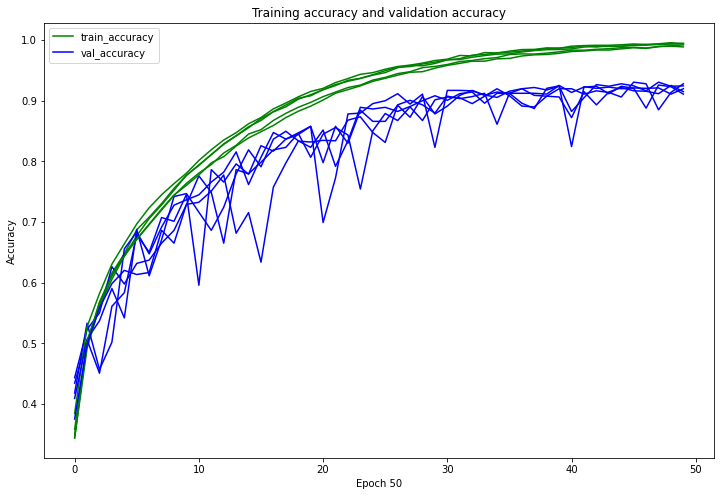

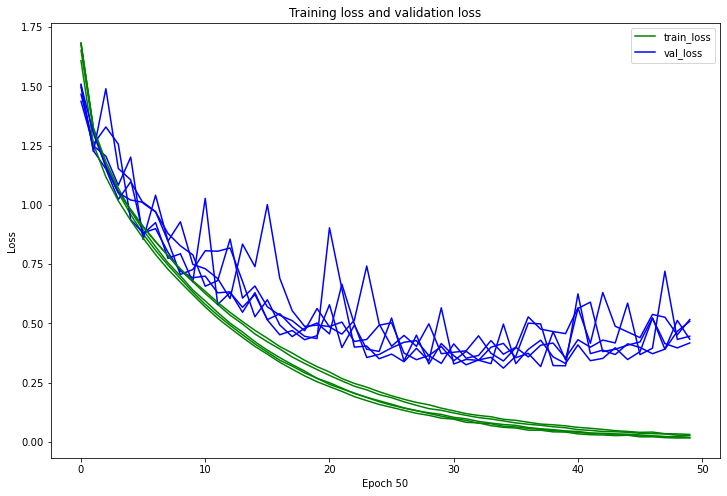

In [33]:
plot_trainAcc_vs_valAcc_for_experiments(res,res1,49,"","accuracy")
plot_trainAcc_vs_valAcc_for_experiments(res,res1,49,"","loss")

## Representamos gráficamente los resultados obtenidos al experimentar con el tamaño del lote

In [72]:
def plot_acc_all_experiments(res,res1,res2,res3,evaluations,evaluations1,evaluations2,evaluations3,epochs):
    plt.figure(figsize=(16,10))
    
    for i in range(len(res)):
        
        precisiones=[]
        precisiones.append(0.0)
        for e in res[i].history["accuracy"]:
            precisiones.append(e)
        
        precisiones1=[]
        precisiones1.append(0.0)
        for e in res1[i].history["accuracy"]:
            precisiones1.append(e)
            
        precisiones2=[]
        precisiones2.append(0.0)
        for e in res2[i].history["accuracy"]:
            precisiones2.append(e)
        
        precisiones3=[]
        precisiones3.append(0.0)
        for e in res3[i].history["accuracy"]:
            precisiones3.append(e)
            
        
        if i == 0:
            plt.plot(np.arange(0, epochs+1), precisiones[0:epochs+1], label="exp_1",color='green')
            plt.plot(np.arange(0, epochs+1), precisiones1[0:epochs+1], label="exp_2",color='blue')
            plt.plot(np.arange(0, epochs+1), precisiones2[0:epochs+1], label="exp_3",color='brown')
            plt.plot(np.arange(0, epochs+1), precisiones3[0:epochs+1], label="exp_4",color='salmon')
        else:
            plt.plot(np.arange(0, epochs+1), precisiones[0:epochs+1],color='green')
            plt.plot(np.arange(0, epochs+1), precisiones1[0:epochs+1],color='blue')
            plt.plot(np.arange(0, epochs+1), precisiones2[0:epochs+1],color='brown')
            plt.plot(np.arange(0, epochs+1), precisiones3[0:epochs+1],color='salmon')

        
    plt.title("Training Accuracy and Test Results")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend()
    plt.savefig("Exp_0_Results.jpg")
    plt.show()
    

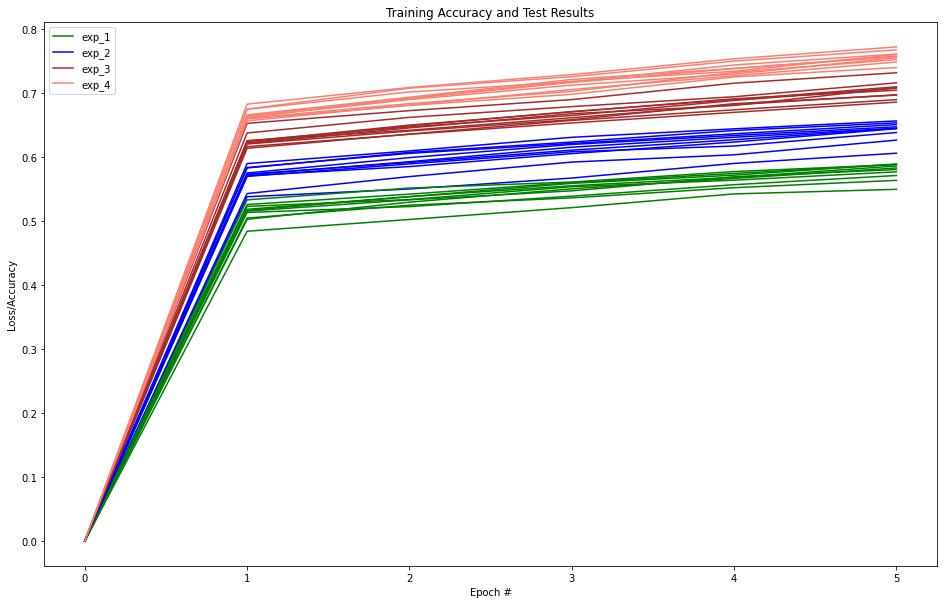

In [73]:
plot_acc_all_experiments(res1,res2,res3,res4,evaluations1,evaluations2,evaluations3,evaluations4,EPOCHS)

## Creamos marcos de datos para analizar los resultados de evaluar los modelos 

In [77]:
precision1 = []
precision2 = []
precision3 = []
precision4 = []

for e in evaluations1:
    element = e[1]
    precision1.append(element)

for e in evaluations2:
    element = e[1]
    precision2.append(element)

for e in evaluations3:
    element = e[1]
    precision3.append(element)

for e in evaluations4:
    element = e[1]
    precision4.append(element)

    
    
d = {'Iteración':[1,2,3,4,5,6,7,8,9,10],'Precision 1': precision1,'Precision 2': precision2,'Precision 3': precision3,'Precision 4': precision4}
df = pd.DataFrame(data=d)

print(df.mean())

Iteración      5.500000
Precision 1    0.453427
Precision 2    0.535929
Precision 3    0.630971
Precision 4    0.693672
dtype: float64


In [31]:
precision1 = []
precision2 = []


for e in evaluations1:
    element = e[1]
    precision2.append(element)


    
    
d = {'Iteración':[1,2,3,4,5],'Precision en test': precision2}
df = pd.DataFrame(data=d)

print(df)
print(df.mean())

   Iteración  Precision en test
0          1           0.934675
1          2           0.923010
2          3           0.927676
3          4           0.928259
4          5           0.915719
Iteración            3.000000
Precision en test    0.925868
dtype: float64
